# Load libraries and utility functions

In [1]:
import ase
import ase.io as ase_io
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# fetch librascal with 
import rascal
from rascal.representations import SphericalInvariants as SOAP
from rascal.representations import SphericalCovariants as lSOAP
from rascal.neighbourlist.structure_manager import (
        mask_center_atoms_by_species, mask_center_atoms_by_id)
from copy import deepcopy

In [2]:
def rasterize(cf):
    for c in cf.collections:
        c.set_rasterized(True)
    return cf

# Loads structures and computes features

These are H2O molecules aligned built along a grid, with varying angle and asymmetric stretch. Energies are computed with the Partridge-Schwenke model, including the dipole, by i-PI

In [3]:
fw = ase_io.read("chemrev_nuprime-theta-grid_computed.xyz", index=":")
nrg = np.loadtxt("pswater-ipi.out")[:,0]
for f, n in zip(fw, nrg[1:]):
    f.info['energy'] = n
y = []
yl = []
rt = []
lw = []
for w in fw:
    rt.append([w.info['OH1'], w.info['OH2'], w.info['HOH'] ])
    y.append(w.info['energy']*27.211386)
    yl.append(w.info['dipole']*2.5417465)
    mask_center_atoms_by_species(w,['O'])
    lw.append(w)
rt = np.asarray(rt)
y = np.asarray(y)
yl = np.asarray(yl)
ntot = len(y)
szgrid = (11,11)

In [4]:
HYPERS = {
    'soap_type': 'PowerSpectrum',
    'interaction_cutoff': 2.0,
    'max_radial': 8,
    'max_angular': 6,
    'gaussian_sigma_constant': 0.5,
    'gaussian_sigma_type': 'Constant',
    'cutoff_smooth_width': 0.5,
    'radial_basis': 'GTO',
    'inversion_symmetry': True,
    'normalize' : True
}
soap2 = SOAP(**HYPERS)

X = soap2.transform(fw).get_features(soap2)

# Builds kernel

In line with the GAP mores, we just do a square kernel

In [5]:
kernel = (X@X.T)**1

In [154]:
nrm = (X**2).sum(axis=1)
gamma = 1.0/(2*1e-1**2)
kgauss = np.exp(-(np.add.outer(nrm,nrm) - 2*X@X.T)*gamma)
kgopt = np.exp(-(np.add.outer(nrm,nrm) - 2*X@X.T)*0.5/(1**2))
#marg = kgauss.sum(axis=1);
#kgauss += marg.sum()/len(marg)**2 - np.add.outer(marg,marg)/len(marg)

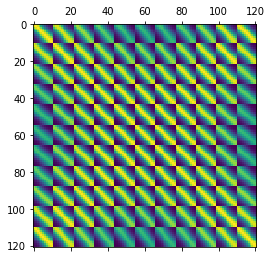

In [155]:
plt.matshow(kgauss)

# Train-test split, and regress

In [156]:
itrain = np.arange(ntot)[::3]
ntrain = 12
np.random.seed(111)
np.random.shuffle(itrain)
itrain = itrain[:ntrain] # np.concatenate( (itrain[:ntrain] , [0,4,8,36,40,44,72,76,80]))
itest = np.setdiff1d(np.arange(ntot), itrain)

In [157]:
#plt.plot(lx[itrain], ly[itrain], 'k*')
#plt.plot(lx[isparse], ly[isparse], 'r+')

In [158]:
#itrain = np.asarray([0,4,8,36,40,44,72,76,80])

In [159]:
w1 = np.linalg.lstsq( kernel[itrain][:,itrain]    + 1e-8*np.eye(len(itrain)), y[itrain], rcond=None)[0]
w2 = np.linalg.lstsq( kernel[itrain][:,itrain]**2 + 1e-8*np.eye(len(itrain)), y[itrain], rcond=None)[0]
wg = np.linalg.lstsq( kgauss[itrain][:,itrain]    + 1e-8*np.eye(len(itrain)), y[itrain], rcond=None)[0]
wgopt = np.linalg.lstsq( kgopt[itrain][:,itrain]  + 1e-8*np.eye(len(itrain)), y[itrain], rcond=None)[0]

In [160]:
ypred_z1 = kernel[:,itrain] @ w1
ypred_z2 = (kernel[:,itrain]**2) @ w2
ypred_g = (kgauss[:,itrain]) @ wg
ypred_gopt = (kgopt[:,itrain]) @ wgopt

In [161]:
np.sqrt(np.mean((ypred_gopt - y)[itest]**2))

0.017947261394336153

In [162]:
(ypred_g-y)[itrain]

array([-4.83059208e-07,  3.23214217e-07,  7.11351321e-07, -3.66907429e-07,
        5.98626502e-08, -2.05477917e-07, -1.25284240e-07, -1.35112059e-06,
       -2.06783840e-07,  8.76574819e-07,  7.33858783e-07, -1.12090910e-07])

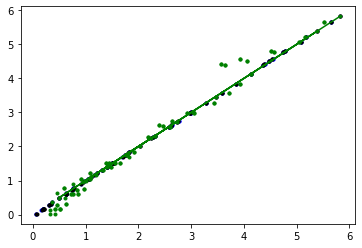

In [163]:
plt.plot(ypred_z1[itrain],y[itrain], 'r.')
plt.plot(ypred_z1[itest], y[itest], 'b.')
plt.plot(ypred_z2[itest], y[itest], 'k.')
plt.plot(ypred_g[itest], y[itest], 'g.')
plt.plot(ypred_g[itrain], y[itrain], 'g-')

# Regularization

In [164]:
reglist = np.geomspace(1e-8, 100, 40)

In [165]:
err = []
for r in reglist:
    w1 = np.linalg.lstsq( kernel[itrain][:,itrain]    + r**2*np.eye(len(itrain)), y[itrain], rcond=None)[0]
    w2 = np.linalg.lstsq( kernel[itrain][:,itrain]**2 + r**2*np.eye(len(itrain)), y[itrain], rcond=None)[0]
    wg = np.linalg.lstsq( kgauss[itrain][:,itrain]    + r**2*np.eye(len(itrain)), y[itrain], rcond=None)[0]
    yp_z1 = kernel[:,itrain] @ w1
    yp_z2 = (kernel[:,itrain]**2) @ w2
    yp_g = (kgauss[:,itrain]) @ wg
    err. append([r, np.sqrt(np.mean((yp_z1 - y)[itest]**2)),
                np.sqrt(np.mean((yp_z2 - y)[itest]**2)),
                np.sqrt(np.mean((yp_g - y)[itest]**2))])
err = np.asarray(err)

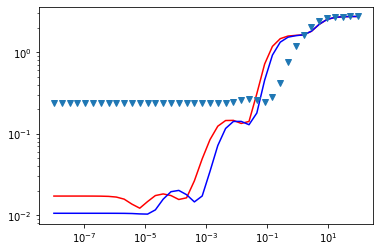

In [166]:
plt.loglog(err[:,0], err[:,1], 'r')
plt.loglog(err[:,0], err[:,2], 'b')
plt.loglog(err[:,0], err[:,3], 'v')

In [167]:
wg = np.linalg.lstsq( kgauss[itrain][:,itrain]    + 1e-4*np.eye(len(itrain)), y[itrain], rcond=None)[0]
yp_g = (kgauss[:,itrain]) @ wg

# Sparse model

In [168]:
itrain = np.arange(ntot)[::3]
ntrain = 12
np.random.seed(111)
np.random.shuffle(itrain)
itrain = itrain[:ntrain] # np.concatenate( (itrain[:ntrain] , [0,4,8,36,40,44,72,76,80]))
itest = np.setdiff1d(np.arange(ntot), itrain)

In [169]:
isparse = np.arange(ntot)[::7]
nsparse = 8
np.random.shuffle(isparse)
isparse = isparse[-nsparse:]

In [170]:
#plt.plot(lx[itrain], ly[itrain], 'k*')
#plt.plot(lx[isparse], ly[isparse], 'r+')

In [171]:
zeta = 2
KNM = (X[itrain]@X[isparse].T)**zeta
KMM = (X[isparse]@X[isparse].T)**zeta

In [172]:
wsparse = np.linalg.lstsq( KNM.T@KNM + 1e-8* KMM, KNM.T@y[itrain], rcond=None)[0]

In [173]:
ypred_sparse = ((X@X[isparse].T)**zeta) @ wsparse

In [174]:
print(np.sqrt(np.mean((y - ypred_sparse)[itest]**2)))

0.024654040602820452


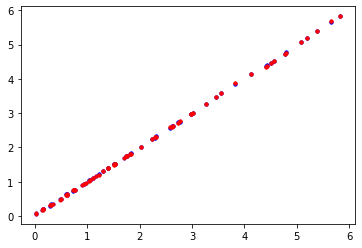

In [175]:
plt.plot(y,ypred_z2,'b.')
plt.plot(y,ypred_sparse,'r.')

# Make plots

In [176]:
gx, gy = np.meshgrid(rt[::11,1]-rt[::11,0], rt[:11,2])
lx = gx.T.flatten()
ly = gy.T.flatten()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


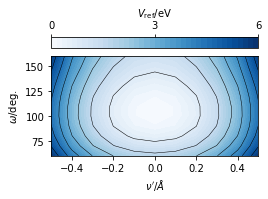

In [177]:
zr= 6
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize = (3.5,2.5))
norm = mpl.colors.Normalize(vmin=0, vmax=zr)
levs= mpl.ticker.MaxNLocator(48, min_n_ticks=1).tick_values(0, zr)
cmap='Blues'
ZS = (y).reshape(szgrid).T
pcm1 = rasterize(ax.contourf(gx, gy, ZS, cmap=cmap, norm=norm, levels=levs))
ax.set_xlabel(r"$\nu'/\AA$")
ax.set_ylabel(r"$\omega/\mathrm{deg.}$")
ax.contour(gx, gy, ZS, colors='k', linewidths=0.5, norm=norm, levels=levs[::5])
#ax.set_xlim(0.695,0.905)
#ax.set_ylim(-0.105,0.105)
#for a, t in zip(ax, [r"$k=x\cdot x'$",r"$k=(x\cdot x')^2)$",r"$k=exp(-|x-x'|^2/\theta)$"]):
#    a.set_title(t,position=(0.97,0.9), 
#                fontsize=9, bbox=dict(facecolor='white', alpha=0.8, pad=1),pad=0,
#               ha='right', va='top')
fig.colorbar(pcm1, ax=ax, label='$V_{\mathrm{ref}}$/eV',
             norm=norm, cmap=cmap, location='top', ticks=range(-9,11,3))
fig.set_constrained_layout_pads(w_pad=1./72., h_pad=1./72.,
        hspace=0., wspace=0.)
fig.savefig("h2o-value.svg")
fig.savefig("h2o-value.pdf")

In [178]:
zr = max(np.concatenate( (np.abs(y-ypred_z1),np.abs(y-ypred_z2),np.abs(y-ypred_g),np.abs(y-ypred_sparse) ) ) )
print(zr)
# manually set
zr = 1

0.8584232962356753


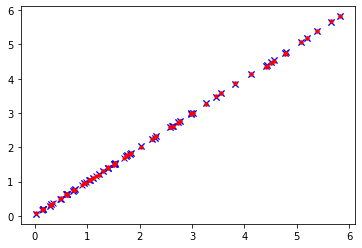

In [179]:
plt.plot(y,ypred_z1,'bx')
plt.plot(y,ypred_sparse,'r.')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


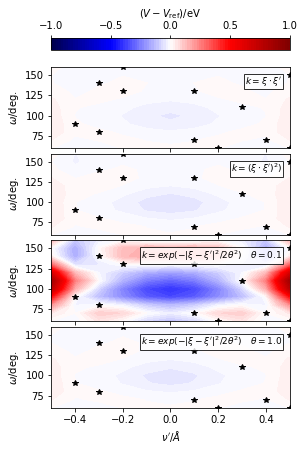

In [184]:
fig, ax = plt.subplots(4, 1, constrained_layout=True, figsize = (4,6))
norm = mpl.colors.Normalize(vmin=-zr, vmax=zr)
levs= mpl.ticker.MaxNLocator(100, min_n_ticks=1).tick_values(-zr, zr)
cmap='seismic'
Z1 = (y - ypred_z1).reshape(szgrid).T
pcm1 = rasterize(ax[0].contourf(gx, gy, Z1, cmap=cmap, norm=norm, levels=levs))
ax[0].plot(lx[itrain], ly[itrain], 'k*')
Z2 = (y - ypred_z2).reshape(szgrid).T
pcm = rasterize(ax[1].contourf(gx, gy, Z2, cmap=cmap, norm=norm, levels=levs))
ax[1].plot(lx[itrain], ly[itrain], 'k*')
ZG = (y - ypred_g).reshape(szgrid).T
pcm = rasterize(ax[2].contourf(gx, gy, ZG, cmap=cmap, norm=norm, levels=levs))
ax[2].plot(lx[itrain], ly[itrain], 'k*')
ZGopt = (y - ypred_gopt).reshape(szgrid).T
pcm = rasterize(ax[3].contourf(gx, gy, ZGopt, cmap=cmap, norm=norm, levels=levs))
ax[3].plot(lx[itrain], ly[itrain], 'k*')

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[2].set_xticklabels([])
ax[3].set_xlabel(r"$\nu'/\AA$")
ax[0].set_ylabel(r"$\omega/\mathrm{deg.}$")
ax[1].set_ylabel(r"$\omega/\mathrm{deg.}$")
ax[2].set_ylabel(r"$\omega/\mathrm{deg.}$")
ax[3].set_ylabel(r"$\omega/\mathrm{deg.}$")
for a, t in zip(ax, [r"$k=\xi\cdot \xi'$",r"$k=(\xi\cdot \xi')^2)$",r"$k=exp(-|\xi-\xi'|^2/2\theta^2)\quad \theta=0.1$",r"$k=exp(-|\xi-\xi'|^2/2\theta^2)\quad \theta=1.0$"]):
    a.set_title(t,position=(0.97,0.9), 
                fontsize=9, bbox=dict(facecolor='white', alpha=0.8, pad=1),pad=0, y=0.9,
               ha='right', va='top')
fig.colorbar(pcm1, ax=ax, label='$(V-V_{\mathrm{ref}})$/eV',  
             norm=norm, cmap=cmap, location='top', ticks=np.arange(-zr,zr+0.1,0.5))
fig.set_constrained_layout_pads(w_pad=1./72., h_pad=1./72.,
        hspace=0., wspace=0.)
fig.savefig("h2o-gpr.svg")
fig.savefig("h2o-gpr.pdf")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  app.launch_new_instance()


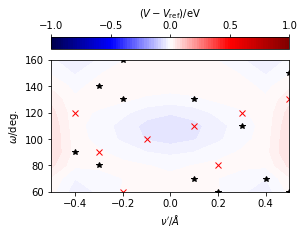

In [181]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize = (4,3))
norm = mpl.colors.Normalize(vmin=-zr, vmax=zr)
levs= mpl.ticker.MaxNLocator(100, min_n_ticks=1).tick_values(-zr, zr)
cmap='seismic'
ZS = (y - ypred_sparse).reshape(szgrid).T
pcm1 = rasterize(ax.contourf(gx, gy, ZS, cmap=cmap, norm=norm, levels=levs))
ax.plot(lx[itrain], ly[itrain], 'k*')
ax.plot(lx[isparse], ly[isparse], 'rx')
ax.set_xlabel(r"$\nu'/\AA$")
ax.set_ylabel(r"$\omega/\mathrm{deg.}$")
#for a, t in zip(ax, [r"$k=x\cdot x'$",r"$k=(x\cdot x')^2)$",r"$k=exp(-|x-x'|^2/\theta)$"]):
#    a.set_title(t,position=(0.97,0.9), 
#                fontsize=9, bbox=dict(facecolor='white', alpha=0.8, pad=1),pad=0,
#               ha='right', va='top')
fig.colorbar(pcm1, ax=ax, label='$(V-V_{\mathrm{ref}})$/eV', 
             norm=norm, cmap=cmap, location='top', ticks=np.arange(-2,2,0.5))
fig.set_constrained_layout_pads(w_pad=1./72., h_pad=1./72.,
        hspace=0., wspace=0.)
fig.savefig("h2o-gpr-base.svg")
fig.savefig("h2o-gpr-base.pdf")

In [182]:
print(np.sqrt(np.mean((y - ypred_sparse)[itest]**2)))
np.sqrt(np.mean((y - ypred_sparse)[itest]**2)/np.mean((y)[itest]**2))

0.024654040602820452


0.008969623056024976

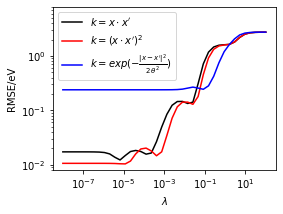

In [183]:
fig,ax = plt.subplots(figsize = (4,3))
ax.loglog(err[:,0], err[:,1], label=r"$k=x\cdot x'$", c='k')
ax.loglog(err[:,0], err[:,2], label=r"$k=(x\cdot x')^2$", c='r')
ax.loglog(err[:,0], err[:,3], label=r"$k=exp(-\frac{|x-x'|^2}{2\theta^2})$", c='b')
ax.legend(loc='upper left')
ax.set_xlabel("$\lambda$")
ax.set_ylabel("RMSE/eV")
ax.set_ylim(8e-3,8)
fig.savefig("h2o-reg.svg")
fig.savefig("h2o-reg.pdf")

# Exponential theta

In [187]:
reglist = np.geomspace(1e-9, 1, 100)
thetalist = np.geomspace(1e-2, 1e2, 100)
nrm = (X**2).sum(axis=1)
kernel = X @ X.T

In [188]:
ert = []
for r in reglist:
    et = []
    for t in thetalist:
        kt = np.exp(-(np.add.outer(nrm,nrm) - 2*X@X.T)*0.5/t**2)
        #marg = kt.sum(axis=1);
        #kt += marg.sum()/len(marg)**2 - np.add.outer(marg,marg)/len(marg)
        wt = np.linalg.lstsq( kt[itrain][:,itrain]    + r**2*np.eye(len(itrain)), y[itrain], rcond=None)[0]
        yp_t = (kt[:,itrain]) @ wt
        et.append([r, t, np.sqrt(np.mean((yp_t - y)[itest]**2))])
    ert.append(et)
ert = np.asarray(ert)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


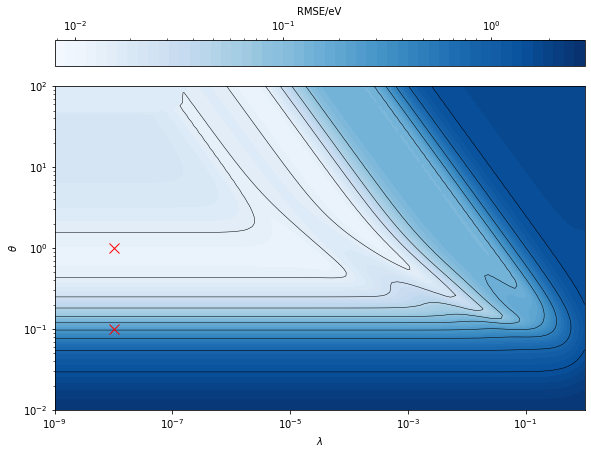

In [192]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize = (8,6))
norm = mpl.colors.LogNorm(vmin=8e-3, vmax=3)
levs= [0.01, 0.1,1,10]
l2 =  mpl.ticker.LogLocator(10,subs=np.geomspace(1,9.9,20)).tick_values(1e-2,1)
l2 = l2[((l2>=0.008) & (l2<3))]
cmap='Blues'
ZS = ert[:,:,2].T
pcm1 = rasterize(ax.contourf(reglist, thetalist, ZS, cmap=cmap, norm=norm,  levels=l2))
ax.contour(reglist, thetalist, ZS, colors='k', linewidths=0.5, norm=norm, levels=l2[::5])
ax.set_ylabel(r"$\theta$")
ax.set_xlabel("$\lambda$")
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xlim(0.695,0.905)
#ax.set_ylim(-0.105,0.105)
#for a, t in zip(ax, [r"$k=x\cdot x'$",r"$k=(x\cdot x')^2)$",r"$k=exp(-|x-x'|^2/\theta)$"]):
#    a.set_title(t,position=(0.97,0.9), 
#                fontsize=9, bbox=dict(facecolor='white', alpha=0.8, pad=1),pad=0,
#               ha='right', va='top')

ax.plot([1e-8], [0.1], 'rx', markersize=10)
ax.plot([1e-8], [1.0], 'rx', markersize=10)

fig.colorbar(pcm1, ax=ax, label='RMSE/eV', 
             norm=norm, cmap=cmap, location='top', ticks=levs)
fig.set_constrained_layout_pads(w_pad=1./72., h_pad=1./72.,
        hspace=0., wspace=0.)
fig.savefig("h2o-exp-theta.svg")
fig.savefig("h2o-exp-theta.pdf")

## Alternative representations

u,v

In [ ]:
Xuv = np.vstack((gx.T.flatten(), gy.T.flatten()/100)).T

In [ ]:
nrm = (Xuv**2).sum(axis=1)
gamma = 1.0/(2*1**2)
kuvgauss = np.exp(-(np.add.outer(nrm,nrm) - 2*Xuv@Xuv.T)*gamma)
wuvg = np.linalg.lstsq( kuvgauss[itrain][:,itrain]    + 1e-8*np.eye(len(itrain)), y[itrain], rcond=None)[0]
ypred_uvg = (kuvgauss[:,itrain]) @ wuvg

In [ ]:
plt.matshow(kuvgauss)

In [ ]:
plt.plot(y,ypred_uvg, 'b.')

In [ ]:
Xpos = []
for w in lw: 
    th = []
    for i in range(1,3):
        th.append(w.positions[i]-w.positions[0])
    #h.sort()
    Xpos.append(np.asarray(th).flatten())
Xpos = np.asarray(Xpos)

In [ ]:
Xpos[55]

In [ ]:
nrm = (Xpos**2).sum(axis=1);
gamma = 1.0/(2*0.2**2)
kposgauss = np.exp(-(np.add.outer(nrm,nrm) - 2*Xpos@Xpos.T)*gamma)
wposg = np.linalg.lstsq( kposgauss[itrain][:,itrain]    + 1e-12*np.eye(len(itrain)), y[itrain], rcond=None)[0]
ypred_posg = (kposgauss[:,itrain]) @ wposg

In [ ]:
plt.matshow(kposgauss)

In [ ]:
print(np.sqrt(np.mean((y-ypred_uvg)**2)))
print(np.sqrt(np.mean((y-ypred_posg)**2)))
print(np.sqrt(np.mean((y-ypred_z2)**2)))
print(np.sqrt(np.mean((y-ypred_gopt)**2)))
print(np.sqrt(np.mean((y-ypred_z1)**2)))

# SA-GPR

brutal calculation of fake dipole (not if they come from pswater!)

In [ ]:
#yl = np.zeros((len(fw),3))
#for i,w in enumerate(fw):
#    yl[i] = w.positions.T @ np.array([-2,1,1])

In [ ]:
print(yl[0], yl[-11])

In [ ]:
HYPERS = {
    'soap_type': 'LambdaSpectrum',
    'interaction_cutoff': 2.0,
    'max_radial': 8,
    'max_angular': 6,
    'gaussian_sigma_constant': 0.5,
    'gaussian_sigma_type': 'Constant',
    'cutoff_smooth_width': 0.5,
    'radial_basis': 'GTO',
    'inversion_symmetry': True,
    'covariant_lambda' : 1
}

lsoap = lSOAP(**HYPERS)
lX = lsoap.transform(fw).get_features(lsoap)

In [ ]:
plt.plot(lX[0],lX[-11],'b.')

In [ ]:
plt.plot(lX[0,:3000])
plt.plot(lX[-11,:3000])

In [ ]:
lX[-11]

In [ ]:
def f2v(vec):
    t = ()
    for s in vec.shape:
        t += (s//3,3)
    return vec.reshape(t)

def v2f(vec):
    t = ()
    for s in vec.shape[:-1:2]:        
        t += tuple([s*3])
    if len(vec.shape)%2==1:
        t += tuple([-1])
    return vec.reshape(t)

reshapes and converts to proper Cartesian (real sph are just y/r, z/r, x/r)

In [ ]:
lX = np.moveaxis(lX.reshape((lX.shape[0],-1,3)),2,1)[:,[2,0,1]]

In [ ]:
lK = f2v(v2f(lX) @ v2f(lX).T)

In [ ]:
lKNM = f2v(v2f(lX[itrain]) @ v2f(lX[isparse]).T)
lKMM = f2v(v2f(lX[isparse]) @ v2f(lX[isparse]).T)
lKM = f2v(v2f(lX) @ v2f(lX[isparse]).T)

In [ ]:
v2f(lKNM).shape

In [ ]:
wlsparse = f2v( np.linalg.lstsq(v2f(lKNM).T@v2f(lKNM) + 1e-8* v2f(lKMM), 
                           v2f(lKNM).T@v2f(yl[itrain]), rcond=None)[0] )

In [ ]:
ylpred_sparse = f2v(v2f(lKM) @ v2f(wlsparse) )

In [ ]:
ylpred_sparse  - yl

In [ ]:
def mu_plot(gx, gy, uv, ax=plt, **kwargs):
    vlen = np.sqrt((uv**2).sum(axis=1))
    vdir = (uv.T/vlen).T
    ax.contourf(gx, gy, vlen.reshape(gx.shape).T, **kwargs)
    ax.quiver(gx, gy,
               vdir[:,0].reshape(gx.shape).T, vdir[:,1].reshape(gx.shape).T,                
               angles='uv', pivot='mid') 
mu_plot(gx, gy, yl, plt, cmap='Blues')

In [ ]:
mu_plot(gx, gy, ylpred_sparse-yl, plt, cmap='Blues')

In [ ]:
ylpred_sparse

In [ ]:
zr = 1e-1
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize = (4,3))
norm = mpl.colors.Normalize(vmin=0, vmax=zr)
levs= mpl.ticker.MaxNLocator(40, min_n_ticks=10).tick_values(0, zr)
cmap='Blues'
uv = (yl - ylpred_sparse)
vlen = np.sqrt((uv**2).sum(axis=1))
pcm1=rasterize(ax.contourf(gx, gy, vlen.reshape(gx.shape).T, cmap=cmap, levels=levs))
ax.quiver(gx, gy, ylpred_sparse[:,0].reshape(gx.shape).T, ylpred_sparse[:,1].reshape(gx.shape).T, color='#505050',
          angles='uv', pivot='mid') 
ax.plot(lx[itrain], ly[itrain], 'k*')
ax.plot(lx[isparse], ly[isparse], 'rx')
ax.set_xlabel(r"$\nu'/\AA$")
ax.set_ylabel(r"$\omega/\mathrm{deg.}$")
ax.set_xlim(-0.52,0.52)
ax.set_ylim(55,165)
fig.colorbar(pcm1, ax=ax, label=r'$|\mu-\mu_{\mathrm{ref}}|$/Debye', 
             norm=norm, cmap=cmap, location='top', ticks=np.arange(0,1,0.1))
fig.set_constrained_layout_pads(w_pad=1./72., h_pad=1./72.,
        hspace=0., wspace=0.)
fig.savefig("h2o-sagpr-base.svg")
fig.savefig("h2o-sagpr-base.pdf")

In [ ]:
yl[:,1].reshape(gx.shape).T[5,5]